# Summary

# Imports

In [1]:
import pyarrow

In [2]:
import concurrent.futures
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats
from sklearn import metrics

from kmtools import py_tools, sequence_tools

In [3]:
%matplotlib inline

In [4]:
pd.set_option("max_columns", 100)

# Parameters

In [5]:
NOTEBOOK_PATH = Path('validation_remote_homology_detection')
NOTEBOOK_PATH

PosixPath('validation_remote_homology_detection')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/validation_remote_homology_detection')

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [8]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [9]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,bd46824,9c5a963"
else:
    assert NETWORK_NAME is not None

In [10]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

# `DATAPKG`

In [11]:
DATAPKG = {}

In [12]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [13]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency-net-v2", "master")
)

In [14]:
DATAPKG['hhsuite-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("hhsuite-wstructure", "master")
)

# Network evaluation

In [15]:
%run trained_networks.ipynb

In [16]:
def predict_with_dcn_old(input_, network_info, network_state):
    from pagnn.prediction.dcn_old import Args, main
    for adj_col in ['adjacency_idx_1', 'adjacency_idx_2']:
        input_[adj_col] = input_.apply(lambda row: np.r_[row[adj_col], 0:len(row['sequence'])], axis=1).values
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

In [17]:
def predict_with_dcn(input_, network_info, network_state):
    from pagnn.prediction.dcn import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

## Remote homology detection

In [18]:
remote_homology_dataset_file = (
    DATAPKG['hhsuite-wstructure']
    .joinpath('scop_remote_homology_detection', 'remote_homology_dataset.parquet')
)

In [19]:
remote_homology_dataset_df = pq.read_table(remote_homology_dataset_file).to_pandas()

In [20]:
display(remote_homology_dataset_df.head(2))
print(len(remote_homology_dataset_df))

,ali_confidence,aligned_cols,evalue,identity,probability,query_ali,query_end,query_id,query_length,query_neff,query_ss_pred,query_start,score,similarity,sum_probs,template_ali,template_end,template_id,template_info,template_length,template_neff,template_ss_dssp,template_ss_pred,template_start,scop_domain,unique_id,query_match_length,template_match_length,identity_calc,coverage_calc,scop_domain_canonical,a2b,b2a,sequence,adjacency_idx_1,adjacency_idx_2
0,356788999999999999999999999999999999753 47...,67,1.300000e-12,0.13,98.65,ITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDR...,75,182362022,79,9.5,,4,62.76,0.261,58.8,PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTE-----NS...,74,d1tuaa1,>d1tuaa1 d.51.1.1 (A:1-84) Hypothetical protei...,72,10.0,,,3,d.51.1.1,182362022-4:75-d1tuaa1-3:74,72,72,0.125000,0.911392,d.51.1.1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTENSMVIVE...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 44, 45, 46, 52, 53, 56, 0, 2, 3, 43, 44..."
1,45678999999999999999999999999999 999873 24...,66,6.200000e-14,0.18,98.89,HMIDVPIPRFAVGIVIGRNGEMIKKIQNDAGV-RIQFKPDDGTTPE...,73,280534567,74,9.8,,3,64.57,0.283,57.9,FHEEFVVREDLMGLAIGTHGSNIQQARKVPGVTAIELDE-----DT...,75,d2cpqa1,>d2cpqa1 d.51.1.1 (A:212-289) Fragile X mental...,68,10.1,,,8,d.51.1.1,280534567-3:73-d2cpqa1-8:75,71,68,0.169014,0.959459,d.51.1.1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",FHEEFVVREDLMGLAIGTHGSNIQQARKVPGVTAIELDEDTGTFRI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 2, 45, 46, 47, 49, 50, 53, 54, 0, 2, 3, 44..."


468


In [21]:
remote_homology_dataset_df['adjacency_coverage_1'] = (
    remote_homology_dataset_df['adjacency_idx_1'].apply(lambda l: len(set(l))) /
    remote_homology_dataset_df['sequence'].str.len()
)


remote_homology_dataset_df['adjacency_coverage_2'] = (
    remote_homology_dataset_df['adjacency_idx_2'].apply(lambda l: len(set(l))) /
    remote_homology_dataset_df['sequence'].str.len()
)

In [22]:
def validate_adjacency_df(adjacency_df):
    assert (adjacency_df['adjacency_idx_1'].apply(min) >= 0).all()
    assert (adjacency_df['adjacency_idx_2'].apply(min) >= 0).all()
    
    assert (
        adjacency_df['adjacency_idx_1'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    assert (
        adjacency_df['adjacency_idx_2'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    
validate_adjacency_df(remote_homology_dataset_df)

### Filter

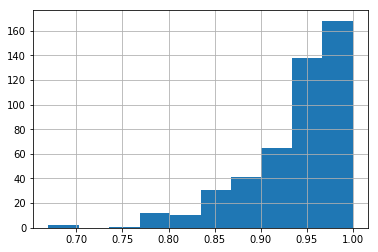

In [23]:
remote_homology_dataset_df['adjacency_coverage_1'].hist()

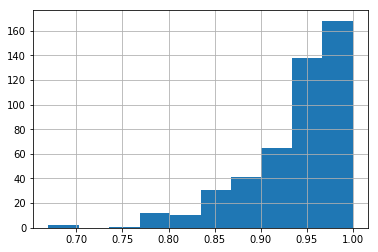

In [24]:
remote_homology_dataset_df['adjacency_coverage_2'].hist()

In [25]:
remote_homology_dataset_filtered = (
    remote_homology_dataset_df[
        (remote_homology_dataset_df['adjacency_coverage_1'] > 0.8) &
        (remote_homology_dataset_df['adjacency_coverage_2'] > 0.8)
    ]
).copy()

In [26]:
remote_homology_dataset_filtered = remote_homology_dataset_df

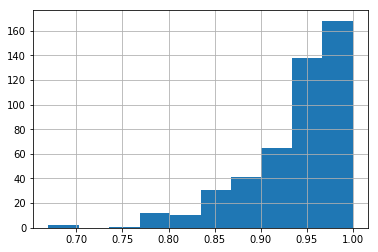

In [27]:
remote_homology_dataset_filtered['adjacency_coverage_2'].hist()

### Make predictions

In [28]:
for scop_level in [1, 2, 3, 4]:
    remote_homology_dataset_filtered[f'scop_domain_matches_l{scop_level}'] = (
        remote_homology_dataset_filtered.apply(
            lambda row: 
                '.'.join(row['scop_domain'].split('.')[:scop_level]) == 
                '.'.join(row['scop_domain_canonical'].split('.')[:scop_level]),
            axis=1,
        )
    )

In [29]:
for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    remote_homology_dataset_filtered[network_name] = (
        predict_with_network(
            remote_homology_dataset_filtered.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

Final output_channels: 256


Initializing custom network


Network name: 'DCN_9c5a963'
Final output_channels: 256


#### `DATA_ALL`

In [33]:
features = (
    [
        "identity_calc",
        "coverage_calc", 
        "identity",
        "score",  # "probability", "evalue",
        "similarity", "sum_probs",
    ] + NETWORK_NAME.split(',')
)

In [45]:
DATA_ALL = {}
for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.dropna(subset=features).copy()
    data = []
#     if f'scop_domain_matches_l{scop_level + 1}' in df:
#         df = df[df[f'scop_domain_matches_l{scop_level + 1}'] == False]
    for feature in features:
        corr, pvalue = stats.spearmanr(df[feature], df[f'scop_domain_matches_l{scop_level}'])
        auc = metrics.roc_auc_score(df[f'scop_domain_matches_l{scop_level}'], df[feature])
        data.append((feature, corr, pvalue, auc))
    out_df = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_ALL[scop_level] = out_df

#### `DATA_GBQ`

In [46]:
DATA_GBQ = {}
for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.dropna(subset=features).copy()
#     if f'scop_domain_matches_l{scop_level + 1}' in df:
#         df = df[df[f'scop_domain_matches_l{scop_level + 1}'] == False]
    data = []
    for feature in features:
        corrs = []
        pvalues = []
        aucs = []
        count = 0
        for query_id, group in df.groupby('query_id'):
            if (len(group) < 3 or
                    len(group[f'scop_domain_matches_l{scop_level}'].drop_duplicates()) == 1 or
                    len(group[feature].drop_duplicates()) == 1
               ):
                continue
            corr, pvalue = stats.spearmanr(group[feature], group[f'scop_domain_matches_l{scop_level}'])
            auc = metrics.roc_auc_score(group[f'scop_domain_matches_l{scop_level}'], group[feature])
            corrs.append(corr)
            pvalues.append(pvalue)
            aucs.append(auc)
            count += 1
        data.append((feature, np.mean(corrs), np.mean(pvalues), np.mean(aucs)))
        print(scop_level, feature, count)
    out_df = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_GBQ[scop_level] = out_df

1 identity_calc 3
1 coverage_calc 3
1 identity 3
1 score 3
1 similarity 3
1 sum_probs 3
1 dcn_old_0 3
1 bd46824 3
1 9c5a963 3
2 identity_calc 2
2 coverage_calc 2
2 identity 2
2 score 2
2 similarity 2
2 sum_probs 2
2 dcn_old_0 2
2 bd46824 2
2 9c5a963 2
3 identity_calc 2
3 coverage_calc 2
3 identity 2
3 score 2
3 similarity 2
3 sum_probs 2
3 dcn_old_0 2
3 bd46824 2
3 9c5a963 2
4 identity_calc 11
4 coverage_calc 11
4 identity 11
4 score 11
4 similarity 11
4 sum_probs 11
4 dcn_old_0 11
4 bd46824 11
4 9c5a963 11


### Plots

In [47]:
cmap = plt.cm.get_cmap('Set1', 10)

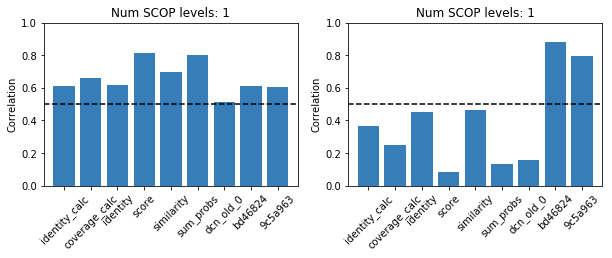

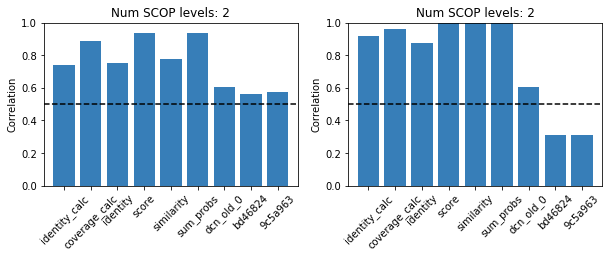

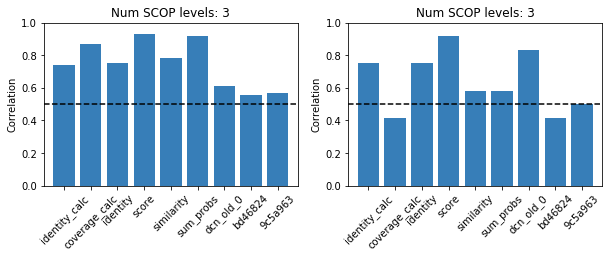

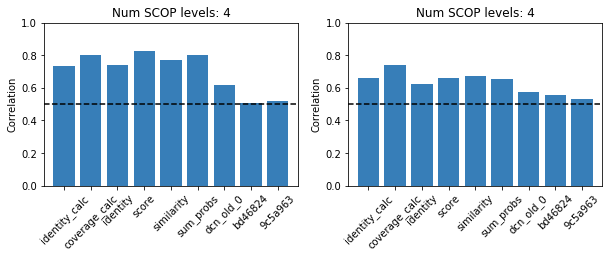

In [48]:
for target in DATA_ALL:
    fg, axs = plt.subplots(1, 2, figsize=(10, 3))

    plt.sca(axs[0])
    df = DATA_ALL[target]
    x = np.arange(len(df))
#     c = [cmap(1) if c >= 0 else cmap(0) for c in df['correlation']]
    c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, df['feature'], rotation=45)
    plt.ylim(0.4, 1)
    plt.ylabel("Correlation")
    plt.title(f"Num SCOP levels: {target}")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0, 1)
    plt.xlim(-0.75, len(features) - 0.25)
    
    plt.sca(axs[1])
    df = DATA_GBQ[target]
    x = np.arange(len(df))
#     c = [cmap(1) if c >= 0 else cmap(0) for c in df['correlation']]
    c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, df['feature'], rotation=45)
    plt.ylabel("Correlation")
    plt.title(f"Num SCOP levels: {target}")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0, 1)
    plt.xlim(-0.75, len(features) - 0.25)